#**Classification models**


In this study, we developed supervised binary classification models using PyCaret (v3.3.2) and trained them on ChEMBL data for selected targets with binary activity labels (active/inactive). Molecular representations included Morgan Chiral fingerprints (radius 2, 2048-bits) and physicochemical descriptors. Key preprocessing steps included z-score normalization, stratified k-fold cross-validation, and imbalance correction via the ADASYN algorithm. To prevent overfitting, early stopping was enabled.

Model evaluation utilized internal and external validations. Data was split into training (80%) and test (20%) sets using Morgan Chiral fingerprints (1024-bits) processed with DeepChem. Internal validation relied on cross-validation, while external validation used the unseen test set. Metrics calculated with PyCaret included Accuracy, AUC, Recall, Precision, F1 score, Kappa, MCC, and Balanced Accuracy, with a focus on MCC as a robust measure of classification quality.

The three top-performing architectures based on average MCC were retrained on the full dataset for each target, maintaining the original hyperparameters. Retraining aimed to enhance MCC values and improve model generalization. Cross-validation during retraining further ensured reliability before using the models for final antiviral activity predictions.

**Note:** This notebook provides an example of the classification model construction for the target IAV_Polymerase (PA).


##**1. Prepare the environment**

In [ ]:
from IPython.utils import io
with io.capture_output() as captured:
  !pip install pycaret
  !pip install datamol
  !pip install rdkit
  !pip install deepchem
import pycaret
import os, os.path, sys, random, subprocess
import datamol as dm
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from pycaret.classification import *
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import deepchem as dc
from imblearn.over_sampling import *
from sklearn.metrics import balanced_accuracy_score

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


###**1.1. Load and prepare the database**

In [ ]:
antivirals = pd.read_excel("/content/7_viralcompound_focusedOnResp_complete_VERSION_2.xlsx")

In [ ]:
# pre-treatment of the data. Unify a column for the target and discard non essential columns
antivirals.columns = antivirals.columns.str.lower()
antivirals = antivirals[['molecule_chembl_id', "acronym", "target", "canonical_smiles_std", "final_classification"]]
antivirals["unique_target"] = antivirals["acronym"].astype(str) + "_" + antivirals["target"].astype(str).replace(" ", "_")
antivirals.drop("acronym", axis = 1, inplace = True)
antivirals.drop("target", axis = 1, inplace = True)
print(antivirals.columns)
print(antivirals.shape)

Index(['molecule_chembl_id', 'canonical_smiles_std', 'final_classification',
       'unique_target'],
      dtype='object')
(4521, 4)


In [ ]:
# transform activity to boolean and discard "mixed" and "unknown" activity molecules
antivirals["activity"] = antivirals["final_classification"].apply(lambda x: 1 if x == "Inhibitor" else (0 if x == "No_Activity" else np.nan))
antivirals.drop("final_classification", axis=1, inplace=True)
antivirals = antivirals[antivirals["activity"].isin([1, 0])].reset_index(drop=True)
print(antivirals.shape)
antivirals.head(2)

(4016, 4)


,molecule_chembl_id,canonical_smiles_std,unique_target,activity
0,CHEMBL222813,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,IAV_Neuraminidase,1.0
1,CHEMBL1229,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...,IAV_Neuraminidase,1.0


###**1.2. Compute relevant descriptors**

In [ ]:
# compute Morgan chiral 2 fingerprint
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 2048, includeChirality = True)
antivirals["fingerprint"] = antivirals["canonical_smiles_std"].apply(lambda x: mfpgen.GetFingerprint(Chem.MolFromSmiles(x)))

In [ ]:
# split each component of the fingerprints in different columns of the dataframe
data = []

for i in antivirals['fingerprint']:
  fp = i.ToBitString()
  data.append(list(fp))

fingerprint_df = pd.DataFrame(data)
fingerprint_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# compute datamol many descriptors
dm_descriptors_df = dm.descriptors.batch_compute_many_descriptors(antivirals["canonical_smiles_std"].apply(dm.to_mol))

In [ ]:
dm_descriptors_df.head(2)

,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,332.133199,0.583333,11,9,1,11,23,6,0,198.22,...,4.374236,0,1,1,0,0,0,0,0,0
1,312.204907,0.750000,6,3,1,6,22,7,0,90.65,...,3.758279,1,0,1,0,0,0,0,0,0


In [ ]:
# Discard unnecesary descriptors
dm_descriptors_df.drop(columns=["n_radical_electrons", "qed", "sas"], inplace=True)
print(dm_descriptors_df.columns)
dm_descriptors_df.head(2)
dm_descriptors_list = dm_descriptors_df.columns.tolist()

Index(['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings',
       'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds', 'tpsa', 'clogp',
       'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles',
       'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles',
       'n_aromatic_rings', 'n_saturated_carbocycles',
       'n_saturated_heterocyles', 'n_saturated_rings'],
      dtype='object')


In [ ]:
# concat the original dataframe to the descriptors type dataframes
antivirals = pd.concat([antivirals, dm_descriptors_df, fingerprint_df], axis=1)
antivirals.drop("fingerprint", axis=1, inplace=True)
antivirals.head(2)

,molecule_chembl_id,canonical_smiles_std,unique_target,activity,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,CHEMBL222813,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,IAV_Neuraminidase,1.0,332.133199,0.583333,11,9,1,11,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1229,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...,IAV_Neuraminidase,1.0,312.204907,0.750000,6,3,1,6,...,0,0,0,0,1,0,0,0,0,0


###**1.3. Select the target to predict**

In [ ]:
antivirals.unique_target.unique()

array(['IAV_Neuraminidase', 'SARS-CoV-2_Mpro', 'IBV_Neuraminidase',
       'SARS-CoV-2_PLP', 'HRV_Capsid protein', 'IAV_Polymerase (PA)',
       'IAV_RdRp', 'HRV_Protease', 'SARS-CoV_Mpro',
       'HRSV_Fusion glycoprotein F0', 'SARS-CoV-2_RdRp',
       'IAV_M2 proton channel', 'SARS-CoV-2_Spike glycoprotein',
       'SARS-CoV-2_MTase (NSP14)', 'IAV_Hemagglutinin',
       'IAV_Polymerase (PB2)', 'SARS-CoV-2_Helicase (NSP13)',
       'SARS-CoV_Helicase (NSP13)', 'MERS-CoV_PLP',
       'SARS-CoV_Spike glycoprotein',
       'HPIV-1_Hemagglutinin-neuraminidase', 'NiV_gpG', 'HRV_Mpro',
       'HCoV-229E_Mpro', 'HRSV_M2 proton channel', 'HRSV_Protein P',
       'HRSV_RdRp', 'HEV-71_Mpro', 'HEV-71_Capsid protein', 'FCoV_Mpro',
       'MERS-CoV_Mpro', 'HCoV-NL63_PLP'], dtype=object)

In [ ]:
# filter de dataframe according to the test target
target_df = antivirals[antivirals["unique_target"] == "IAV_Polymerase (PA)"].reset_index(drop = True)
print(target_df.shape)
print(target_df.columns)
target_df.head(2)

(256, 2071)
Index([  'molecule_chembl_id', 'canonical_smiles_std',        'unique_target',
                   'activity',                   'mw',                 'fsp3',
             'n_lipinski_hba',       'n_lipinski_hbd',              'n_rings',
             'n_hetero_atoms',
       ...
                         2038,                   2039,                   2040,
                         2041,                   2042,                   2043,
                         2044,                   2045,                   2046,
                         2047],
      dtype='object', length=2071)


,molecule_chembl_id,canonical_smiles_std,unique_target,activity,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,CHEMBL463590,O=C(O)/C(O)=C/C(=O)C1(Cc2ccc(Cl)cc2)CCN(Cc2ccc...,IAV_Polymerase (PA),1.0,413.139386,0.304348,5,2,3,6,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL2040554,O=C(O)/C(O)=C/C(=O)C1(Cc2ccc(Cl)cc2)CCN(CC2CCC...,IAV_Polymerase (PA),1.0,419.186336,0.565217,5,2,3,6,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

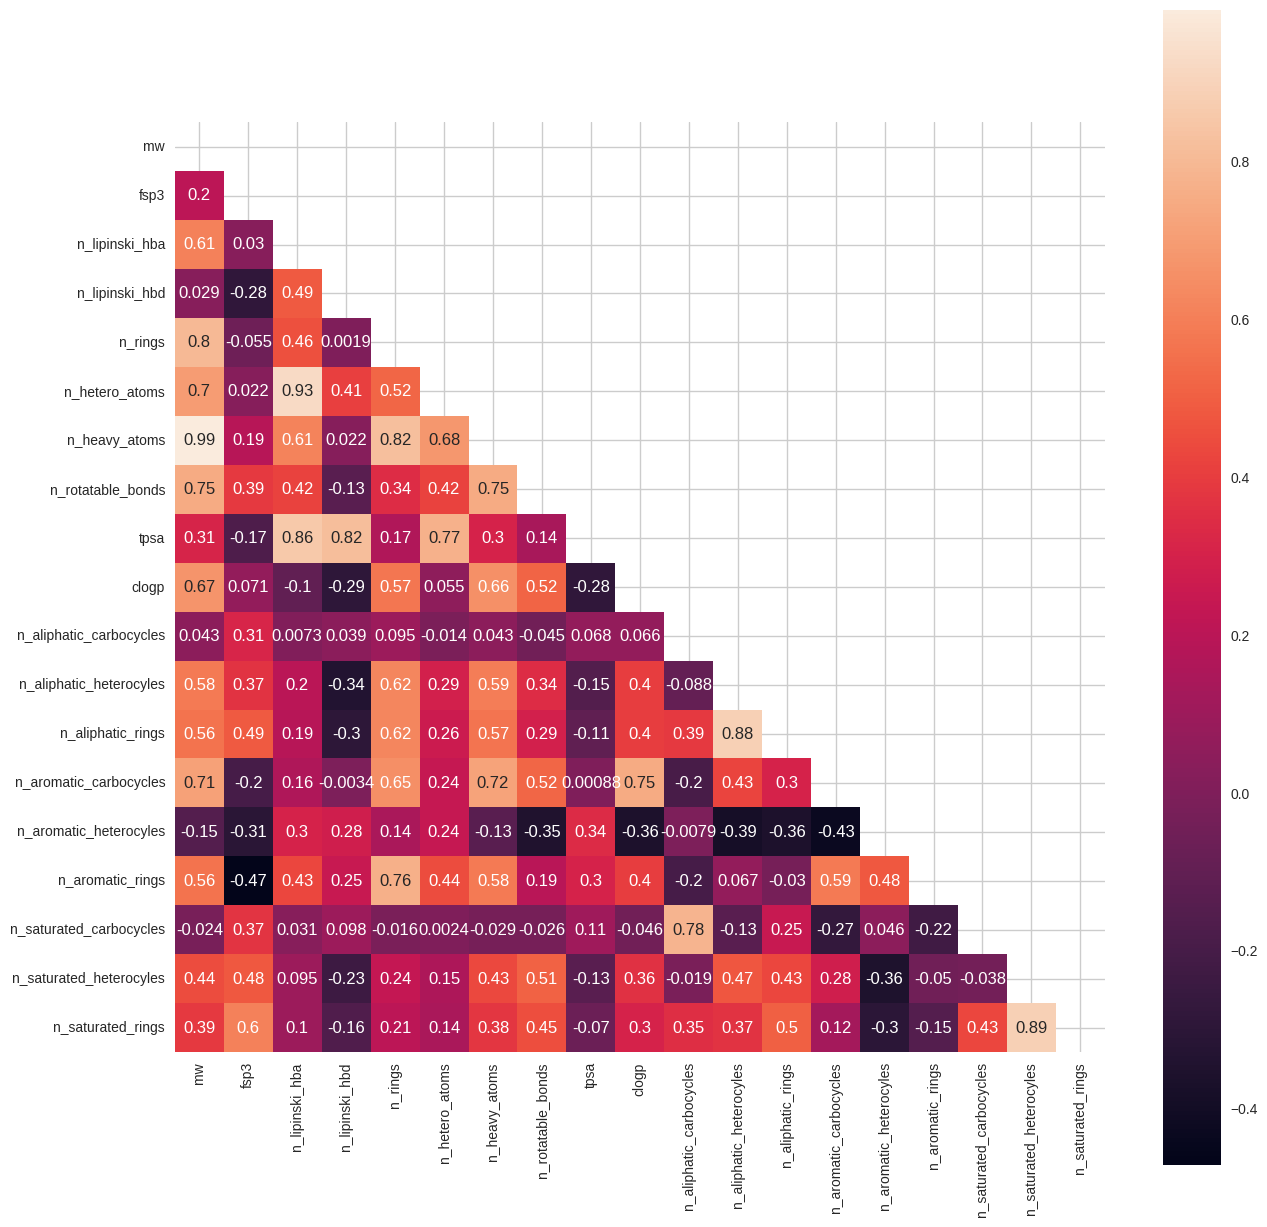

In [ ]:
# compute correlation among druglike descriptors within the target data set

correlation = target_df[dm_descriptors_list].corr()

# np.triu is a Numpy function to compute the superior triangle of a square matrix

upper_triangle = np.triu(correlation)
fig = plt.gcf()
fig.set_size_inches(15, 15)
sns.heatmap(data = correlation, mask = upper_triangle, square = True, annot = True)

In [ ]:
def drop_highly_correlated(df, threshold, columns_range = None):
  """compute the Pearson pairwise correlation among the specified range of columns
  and deletes the second columns of each pair of highly correlated columns
  if the correlation is superior to the specified threshold.

  Parameters

  df: DataFrame
  threshold: float
  columns_range: list of columns, default is all columns

  returns:
  DataFrame with highly correlated columns deleted
  List of remaining columns
  """
  if columns_range:
    df_correlation = df[columns_range].corr(method = "pearson")
  else:
    df_correlation = df.corr(method = "pearson")

  # create a set to hold the names of columns to drop
  columns_to_drop = set()

  # iterate through the columns of the correlation matrix
  for i in range(len(df_correlation.columns)):
    for j in range(i + 1, len(df_correlation.columns)):
      # if the correlation between the two columns is greater than the threshold
      if abs(df_correlation.iloc[i, j]) > threshold:
        # add the second column to the set of columns to drop
        columns_to_drop.add(df_correlation.columns[j])

  # drop the columns in the set from the DataFrame
  df = df.drop(columns = columns_to_drop)
  remaining_columns = [col for col in df_correlation.columns if col not in columns_to_drop]

  # return the DataFrame and the list of remaining columns
  print(f"The removed columns were {len(columns_to_drop)}:\n {columns_to_drop}")

  return df, remaining_columns

In [ ]:
filtered_target_df, descriptors_list = drop_highly_correlated(target_df, 0.8, dm_descriptors_list)

The removed columns were 6:
 {'n_saturated_rings', 'tpsa', 'n_aliphatic_rings', 'n_hetero_atoms', 'n_heavy_atoms', 'n_rings'}


<Axes: >

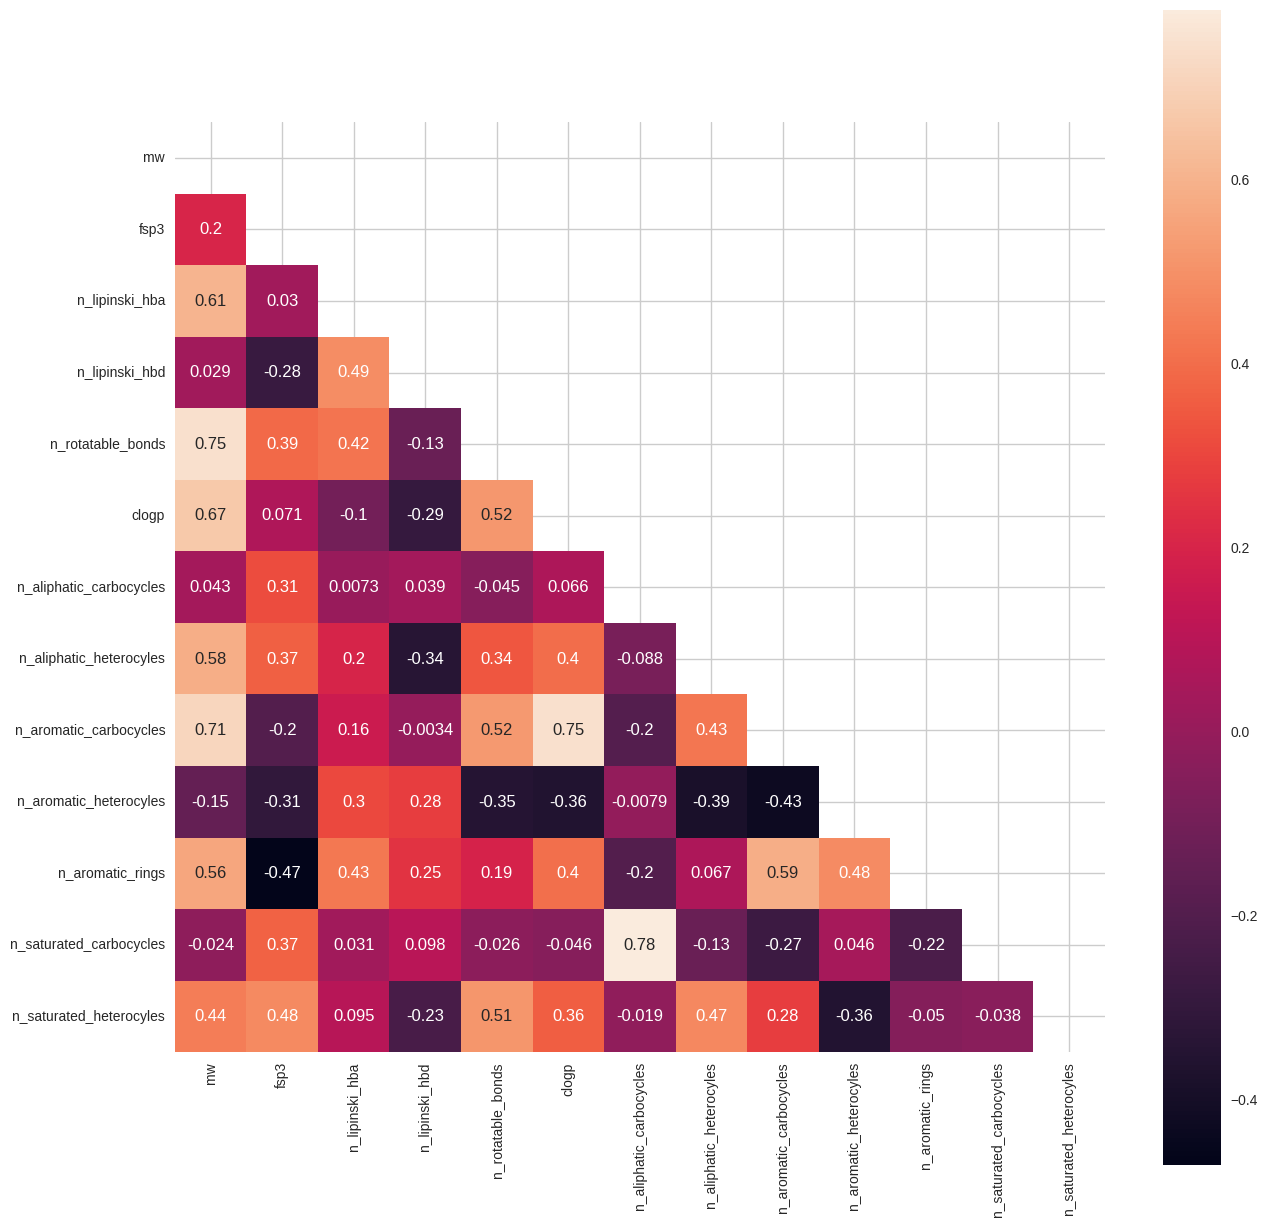

In [ ]:
# compute correlation within druglike remaining descriptors

correlation = filtered_target_df[descriptors_list].corr()

# np.triu is a Numpy function to compute the superior triangle of a square matrix

upper_triangle = np.triu(correlation)
fig = plt.gcf()
fig.set_size_inches(15, 15)
sns.heatmap(data = correlation, mask = upper_triangle, square = True, annot = True)

In [ ]:
unique_target = filtered_target_df.unique_target[0]
print(unique_target)

IAV_Polymerase (PA)


In [ ]:
# save dataframe as csv
filtered_target_df.to_csv(f"{unique_target}_molecules.csv", index=False)

###**1.4. Split and save data sets**

In [ ]:
print(f"The proportion of actives in the data set is: {round(filtered_target_df.activity.value_counts()[1] / len(filtered_target_df), 3)}")

The proportion of actives in the data set is: 0.59


In [ ]:
# load the data into the Data Loader from DeepChem
# transform the data into numpy arrays, and load to the Dataset format
x = filtered_target_df.drop(columns="activity").to_numpy()
y = filtered_target_df["activity"].values.astype(float)

dataset = dc.data.DiskDataset.from_numpy(
    X = x,
    y = y,
    w = x,
    ids = filtered_target_df["canonical_smiles_std"].tolist()
)

In [ ]:
fingerprint_splitter = dc.splits.FingerprintSplitter()

In [ ]:
# perform the train-test split fingerprint-based with 80% training fraction
train, test = fingerprint_splitter.train_test_split(dataset, frac_train = 0.8)

[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerator
[03:08:32] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
# convert train and test IDs to sets for faster managing
train_ids = set(train.ids)
test_ids = set(test.ids)

In [ ]:
# Filter the DataFrame by using set membership
train_df = filtered_target_df[filtered_target_df["canonical_smiles_std"].isin(train_ids)].reset_index(drop = True)
test_df = filtered_target_df[filtered_target_df["canonical_smiles_std"].isin(test_ids)].reset_index(drop = True)

In [ ]:
# save dataframes as csv
train_df.to_csv(f"train_{unique_target}.csv", index=False)
test_df.to_csv(f"test_{unique_target}.csv", index=False)

In [ ]:
print(f"The number of molecules selected to build the models is: {len(train_df)}\n"
f"The number of molecules selected to test the model is: {len(test_df)}")

print(f"Proportion of actives in training set is: {round(train_df.activity.value_counts()[1] / len(train_df), 3)}\n"
f"Proportion of actives in testing set is: {round(test_df.activity.value_counts()[1] / len(test_df), 3)}")

The number of molecules selected to build the models is: 204
The number of molecules selected to test the model is: 52
Proportion of actives in training set is: 0.559
Proportion of actives in testing set is: 0.712


In [ ]:
print(f"The lenght of each data set is: train ({len(train_df)}), test ({len(test_df)}), original data set ({len(filtered_target_df)}), sum ({len(train_df) + len(test_df)})")

The lenght of each data set is: train (204), test (52), original data set (256), sum (256)


##**2. Train models with fingerprint data set splitting**

In [ ]:
adasyn1 = ADASYN(sampling_strategy = 'minority')

In [ ]:
train_df = pd.read_csv("/content/train_IAV_Polymerase (PA).csv")

In [ ]:
unique_target = train_df.unique_target[0]
print(unique_target)

IAV_Polymerase (PA)


In [ ]:
train_df = train_df.drop(["molecule_chembl_id", "canonical_smiles_std", "unique_target"], axis=1)

In [ ]:
if 0.4 <= (train_df.activity.value_counts()[1] / len(train_df)) <= 0.6:

  best_models = setup(data = train_df, target = "activity", session_id = 123, log_experiment = False,
                      normalize = True, fold_shuffle = True, fix_imbalance = False)

else:

  best_models = setup(data = train_df, target = "activity", session_id = 123, log_experiment = False,
                      normalize = True, fold_shuffle = True, fix_imbalance = True,
                      fix_imbalance_method = adasyn1)

,Description,Value
0,Session id,123
1,Target,activity
2,Target type,Binary
3,Original data shape,"(204, 2062)"
4,Transformed data shape,"(204, 2062)"
5,Transformed train set shape,"(142, 2062)"
6,Transformed test set shape,"(62, 2062)"
7,Numeric features,2061
8,Preprocess,True
9,Imputation type,simple


In [ ]:
add_metric("B. Accuracy", "BA", balanced_accuracy_score)

,B._Accuracy
Name,BA
Display Name,BA
Score Function,<pycaret.internal.metrics.EncodedDecodedLabels...
Scorer,"make_scorer(balanced_accuracy_score, response_..."
Target,pred
Args,{}
Greater is Better,True
Multiclass,True
Custom,True


In [ ]:
# models training to compare the best architectures
models = compare_models(sort = "MCC", n_select = 15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA,TT (Sec)
ridge,Ridge Classifier,0.8810,0.9359,0.9500,0.8611,0.8995,0.7558,0.7709,0.8750,0.7620
lr,Logistic Regression,0.8667,0.9383,0.9500,0.8388,0.8885,0.7254,0.7403,0.8583,1.8490
rf,Random Forest Classifier,0.8524,0.9436,0.9250,0.8404,0.8751,0.6980,0.7164,0.8470,0.6350
gbc,Gradient Boosting Classifier,0.8514,0.9159,0.9375,0.8284,0.8752,0.6960,0.7150,0.8438,1.0370
et,Extra Trees Classifier,0.8519,0.9395,0.8875,0.8620,0.8693,0.6996,0.7120,0.8509,0.8520
svm,SVM - Linear Kernel,0.8310,0.8818,0.8857,0.8348,0.8539,0.6525,0.6676,0.8238,0.4600
ada,Ada Boost Classifier,0.8295,0.8642,0.8589,0.8516,0.8472,0.6514,0.6659,0.8247,0.5890
xgboost,Extreme Gradient Boosting,0.8233,0.9039,0.8750,0.8267,0.8426,0.6417,0.6579,0.8196,2.6230
dt,Decision Tree Classifier,0.8162,0.8107,0.9000,0.8242,0.8485,0.6241,0.6545,0.8107,0.9030
lightgbm,Light Gradient Boosting Machine,0.7948,0.8861,0.8125,0.8286,0.8098,0.5891,0.6066,0.7967,1.2230


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
statistics_trained_models = pull()
names = statistics_trained_models.index.tolist()
statistics_trained_models = statistics_trained_models.sort_values("Model")
statistics_trained_models.to_csv(f"statistics_trained_models_{unique_target}.csv", index = False)
statistics_trained_models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA,TT (Sec)
ada,Ada Boost Classifier,0.8295,0.8642,0.8589,0.8516,0.8472,0.6514,0.6659,0.8247,0.589
dt,Decision Tree Classifier,0.8162,0.8107,0.9000,0.8242,0.8485,0.6241,0.6545,0.8107,0.903
dummy,Dummy Classifier,0.5567,0.5000,1.0000,0.5567,0.7149,0.0000,0.0000,0.5000,0.544
et,Extra Trees Classifier,0.8519,0.9395,0.8875,0.8620,0.8693,0.6996,0.7120,0.8509,0.852
xgboost,Extreme Gradient Boosting,0.8233,0.9039,0.8750,0.8267,0.8426,0.6417,0.6579,0.8196,2.623
gbc,Gradient Boosting Classifier,0.8514,0.9159,0.9375,0.8284,0.8752,0.6960,0.7150,0.8438,1.037
knn,K Neighbors Classifier,0.7467,0.9093,0.9750,0.7039,0.8133,0.4527,0.5262,0.7173,0.517
lightgbm,Light Gradient Boosting Machine,0.7948,0.8861,0.8125,0.8286,0.8098,0.5891,0.6066,0.7967,1.223
lda,Linear Discriminant Analysis,0.6543,0.6431,0.6357,0.7061,0.6652,0.3122,0.3140,0.6571,0.487
lr,Logistic Regression,0.8667,0.9383,0.9500,0.8388,0.8885,0.7254,0.7403,0.8583,1.849


####**2.1. Models tunning**

In [ ]:
tuned_models = [tune_model(model, optimize = "MCC", early_stopping = True) for model in models]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8000,0.9821,1.0000,0.7273,0.8421,0.5872,0.6447,0.7857
1,0.8667,1.0000,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
2,0.7857,0.8125,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8571,0.8958,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
5,0.9286,0.8333,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
6,0.9286,1.0000,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
7,0.8571,0.9375,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
8,0.9286,1.0000,0.8750,1.0000,0.9333,0.8571,0.8660,0.9375


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8000,0.9821,1.0000,0.7273,0.8421,0.5872,0.6447,0.7857
1,0.8667,1.0000,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
2,0.7857,0.8125,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8571,0.9167,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
5,0.9286,0.8333,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
6,0.9286,1.0000,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
7,0.8571,0.9583,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
8,0.9286,0.9792,0.8750,1.0000,0.9333,0.8571,0.8660,0.9375


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.9464,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.8000,0.8929,0.8750,0.7778,0.8235,0.5946,0.6001,0.7946
2,0.7857,0.8542,1.0000,0.7273,0.8421,0.5333,0.6030,0.7500
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.7857,0.8542,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
5,0.7143,0.8125,0.7500,0.7500,0.7500,0.4167,0.4167,0.7083
6,0.6429,0.8542,0.6250,0.7143,0.6667,0.2857,0.2887,0.6458
7,0.7857,0.8750,0.7500,0.8571,0.8000,0.5714,0.5774,0.7917
8,0.9286,0.9167,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.8750,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.9333,0.9643,1.0000,0.8889,0.9412,0.8649,0.8729,0.9286
2,0.7857,0.8125,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
3,0.9286,1.0000,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
4,0.7857,0.8750,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
5,0.7857,0.8750,0.7500,0.8571,0.8000,0.5714,0.5774,0.7917
6,0.8571,0.8333,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
7,0.7143,0.9375,0.6250,0.8333,0.7143,0.4400,0.4583,0.7292
8,0.8571,0.9167,0.7500,1.0000,0.8571,0.7200,0.7500,0.8750


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.9464,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.7333,0.9286,0.7500,0.7500,0.7500,0.4643,0.4643,0.7321
2,0.8571,0.8750,1.0000,0.8000,0.8889,0.6957,0.7303,0.8333
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.7857,0.8750,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
5,0.7143,0.8542,0.6250,0.8333,0.7143,0.4400,0.4583,0.7292
6,0.7143,0.8333,0.7500,0.7500,0.7500,0.4167,0.4167,0.7083
7,0.7857,0.8750,0.7500,0.8571,0.8000,0.5714,0.5774,0.7917
8,0.7857,0.9167,0.7500,0.8571,0.8000,0.5714,0.5774,0.7917


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.9821,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.9333,1.0000,1.0000,0.8889,0.9412,0.8649,0.8729,0.9286
2,0.7857,0.8750,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8571,0.9375,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
5,0.8571,0.8333,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
6,0.9286,0.9792,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
7,0.9286,0.9167,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.9821,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.9333,0.9464,1.0000,0.8889,0.9412,0.8649,0.8729,0.9286
2,0.7857,0.8750,1.0000,0.7273,0.8421,0.5333,0.6030,0.7500
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.7857,0.9271,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
5,0.6429,0.7917,0.6250,0.7143,0.6667,0.2857,0.2887,0.6458
6,0.9286,0.9271,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
7,0.6429,0.7708,0.6250,0.7143,0.6667,0.2857,0.2887,0.6458
8,0.9286,0.9375,0.8750,1.0000,0.9333,0.8571,0.8660,0.9375


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.9286,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.8000,0.9107,1.0000,0.7273,0.8421,0.5872,0.6447,0.7857
2,0.7857,0.8125,1.0000,0.7273,0.8421,0.5333,0.6030,0.7500
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.7857,0.8542,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
5,0.9286,0.8750,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
6,0.8571,0.8750,1.0000,0.8000,0.8889,0.6957,0.7303,0.8333
7,0.7857,0.8542,1.0000,0.7273,0.8421,0.5333,0.6030,0.7500
8,0.8571,0.9583,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.8214,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.8000,0.8393,0.8750,0.7778,0.8235,0.5946,0.6001,0.7946
2,0.7143,0.7812,0.8750,0.7000,0.7778,0.3913,0.4108,0.6875
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.5714,0.7813,0.3750,0.7500,0.5000,0.1923,0.2282,0.6042
5,0.7143,0.7083,0.7500,0.7500,0.7500,0.4167,0.4167,0.7083
6,0.8571,0.8333,1.0000,0.8000,0.8889,0.6957,0.7303,0.8333
7,0.9286,0.9688,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
8,0.8571,0.9062,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.9333,0.9643,1.0000,0.8889,0.9412,0.8649,0.8729,0.9286
1,0.8667,0.9286,0.8750,0.8750,0.8750,0.7321,0.7321,0.8661
2,0.7143,0.8333,0.7500,0.7500,0.7500,0.4167,0.4167,0.7083
3,0.8571,0.9792,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
4,0.7143,0.7292,0.7500,0.7500,0.7500,0.4167,0.4167,0.7083
5,0.8571,0.7708,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
6,0.8571,0.8958,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
7,0.7143,0.8542,0.6250,0.8333,0.7143,0.4400,0.4583,0.7292
8,0.9286,0.9375,0.8750,1.0000,0.9333,0.8571,0.8660,0.9375


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.7333,0.7857,1.0000,0.6667,0.8000,0.4444,0.5345,0.7143
1,0.7333,0.8036,0.8750,0.7000,0.7778,0.4545,0.4725,0.7232
2,0.7143,0.7500,0.8750,0.7000,0.7778,0.3913,0.4108,0.6875
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.7143,0.7917,1.0000,0.6667,0.8000,0.3636,0.4714,0.6667
5,0.7857,0.8333,0.7500,0.8571,0.8000,0.5714,0.5774,0.7917
6,0.9286,0.9375,0.8750,1.0000,0.9333,0.8571,0.8660,0.9375
7,0.6429,0.8438,0.8750,0.6364,0.7368,0.2222,0.2513,0.6042
8,0.7857,0.7812,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8667,0.8482,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
1,0.8667,0.9464,0.8750,0.8750,0.8750,0.7321,0.7321,0.8661
2,0.8571,0.7812,1.0000,0.8000,0.8889,0.6957,0.7303,0.8333
3,0.8571,0.9583,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
4,0.8571,0.8854,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
5,0.9286,0.8854,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
6,0.7143,0.8646,0.7500,0.7500,0.7500,0.4167,0.4167,0.7083
7,0.7857,0.8542,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
8,0.7857,0.9062,0.7500,0.8571,0.8000,0.5714,0.5774,0.7917


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.8000,0.9821,1.0000,0.7273,0.8421,0.5872,0.6447,0.7857
1,0.8667,1.0000,1.0000,0.8000,0.8889,0.7273,0.7559,0.8571
2,0.7857,0.7917,0.8750,0.7778,0.8235,0.5532,0.5594,0.7708
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8571,0.8958,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
5,0.9286,0.8333,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
6,0.9286,1.0000,1.0000,0.8889,0.9412,0.8511,0.8607,0.9167
7,0.8571,0.9375,0.8750,0.8750,0.8750,0.7083,0.7083,0.8542
8,0.9286,1.0000,0.8750,1.0000,0.9333,0.8571,0.8660,0.9375


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.3333,0.3929,0.0000,0.0000,0.0000,-0.2712,-0.4193,0.3571
1,0.3333,0.3750,0.2500,0.3333,0.2857,-0.3158,-0.3273,0.3393
2,0.3571,0.2292,0.2500,0.4000,0.3077,-0.2353,-0.2582,0.3750
3,0.5000,0.2708,0.7500,0.5455,0.6316,-0.0889,-0.1005,0.4583
4,0.3571,0.3333,0.2500,0.4000,0.3077,-0.2353,-0.2582,0.3750
5,0.3571,0.2083,0.5000,0.4444,0.4706,-0.3404,-0.3443,0.3333
6,0.2143,0.2083,0.2500,0.2857,0.2667,-0.5714,-0.5774,0.2083
7,0.5714,0.3542,0.3750,0.7500,0.5000,0.1923,0.2282,0.6042
8,0.3571,0.5000,0.2500,0.4000,0.3077,-0.2353,-0.2582,0.3750


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
Fold,,,,,,,,
0,0.4667,0.5000,0.3750,0.5000,0.4286,-0.0526,-0.0546,0.4732
1,0.6000,0.5000,0.5000,0.6667,0.5714,0.2105,0.2182,0.6071
2,0.2857,0.5000,0.2500,0.3333,0.2857,-0.4000,-0.4167,0.2917
3,0.5714,0.5000,0.5000,0.6667,0.5714,0.1600,0.1667,0.5833
4,0.4286,0.5000,0.3750,0.5000,0.4286,-0.1200,-0.1250,0.4375
5,0.7143,0.5000,0.6250,0.8333,0.7143,0.4400,0.4583,0.7292
6,0.4286,0.5000,0.3750,0.5000,0.4286,-0.1200,-0.1250,0.4375
7,0.5714,0.5000,0.5000,0.6667,0.5714,0.1600,0.1667,0.5833
8,0.7143,0.5000,0.6250,0.8333,0.7143,0.4400,0.4583,0.7292


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [ ]:
compare_models(tuned_models, sort = "MCC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA,TT (Sec)
5,SVM - Linear Kernel,0.9014,0.9524,0.9625,0.8772,0.9161,0.7978,0.8072,0.8955,0.5510
0,Ridge Classifier,0.8810,0.9359,0.9500,0.8611,0.8995,0.7558,0.7709,0.8750,0.5910
1,Logistic Regression,0.8810,0.9380,0.9500,0.8611,0.8995,0.7558,0.7709,0.8750,0.5230
12,Linear Discriminant Analysis,0.8810,0.9338,0.9500,0.8611,0.8995,0.7558,0.7709,0.8750,3.4390
2,Random Forest Classifier,0.8524,0.9436,0.9250,0.8404,0.8751,0.6980,0.7164,0.8470,0.7540
3,Gradient Boosting Classifier,0.8514,0.9159,0.9375,0.8284,0.8752,0.6960,0.7150,0.8438,0.8330
4,Extra Trees Classifier,0.8519,0.9395,0.8875,0.8620,0.8693,0.6996,0.7120,0.8509,0.8880
7,Extreme Gradient Boosting,0.8310,0.8926,0.9750,0.7907,0.8681,0.6475,0.6874,0.8161,2.4400
6,Ada Boost Classifier,0.8295,0.8642,0.8589,0.8516,0.8472,0.6514,0.6659,0.8247,0.8550
11,K Neighbors Classifier,0.8305,0.8838,0.8857,0.8249,0.8517,0.6536,0.6626,0.8238,0.4800


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

SGDClassifier(alpha=0.05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.3900000001, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
statistics_tuned_models = pull().sort_values("Model").reset_index(drop = True)
statistics_tuned_models.to_csv(f"statistics_tuned_models_{unique_target}.csv", index = False)
statistics_tuned_models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA,TT (Sec)
0,Ada Boost Classifier,0.8295,0.8642,0.8589,0.8516,0.8472,0.6514,0.6659,0.8247,0.855
1,Decision Tree Classifier,0.8162,0.8107,0.9000,0.8242,0.8485,0.6241,0.6545,0.8107,0.717
2,Dummy Classifier,0.5281,0.5000,0.4554,0.6000,0.5176,0.0718,0.0747,0.5372,0.441
3,Extra Trees Classifier,0.8519,0.9395,0.8875,0.8620,0.8693,0.6996,0.7120,0.8509,0.888
4,Extreme Gradient Boosting,0.8310,0.8926,0.9750,0.7907,0.8681,0.6475,0.6874,0.8161,2.440
5,Gradient Boosting Classifier,0.8514,0.9159,0.9375,0.8284,0.8752,0.6960,0.7150,0.8438,0.833
6,K Neighbors Classifier,0.8305,0.8838,0.8857,0.8249,0.8517,0.6536,0.6626,0.8238,0.480
7,Light Gradient Boosting Machine,0.8157,0.8689,0.8357,0.8389,0.8339,0.6281,0.6335,0.8155,1.055
8,Linear Discriminant Analysis,0.8810,0.9338,0.9500,0.8611,0.8995,0.7558,0.7709,0.8750,3.439
9,Logistic Regression,0.8810,0.9380,0.9500,0.8611,0.8995,0.7558,0.7709,0.8750,0.523


In [ ]:
final_models = [finalize_model(model) for model in tuned_models]

In [ ]:
for model, name in zip(final_models, names):
  save_model(model, f"{unique_target}_{name}")

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


In [ ]:
imported_models = []
for name in names:
  imported_models.append(load_model(f"{unique_target}_{name}"))

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [ ]:
test_df = pd.read_csv("/content/test_IAV_Polymerase (PA).csv")

In [ ]:
predictions = []
statistics_unseen = pd.DataFrame()

for model in imported_models:
  predictions.append(predict_model(model, data = test_df))
  statistics_unseen = pd.concat([statistics_unseen, pull()], axis = 0).reset_index(drop = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Ridge Classifier,0.7885,0.7523,0.8378,0.8611,0.8493,0.4947,0.4952,0.7523


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Logistic Regression,0.8077,0.8829,0.8919,0.8462,0.8684,0.5122,0.5147,0.7459


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Random Forest Classifier,0.8269,0.9279,0.9459,0.8333,0.8861,0.5320,0.5509,0.7396


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Gradient Boosting Classifier,0.8654,0.9243,0.8919,0.9167,0.9041,0.6784,0.6792,0.8459


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Extra Trees Classifier,0.9038,0.9387,0.8919,0.9706,0.9296,0.7789,0.7859,0.9126


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,SVM - Linear Kernel,0.8846,0.8793,0.8919,0.9429,0.9167,0.7296,0.7326,0.8793


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Ada Boost Classifier,0.8269,0.8856,0.8649,0.8889,0.8767,0.5866,0.5872,0.7991


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Extreme Gradient Boosting,0.7308,0.9189,0.9189,0.7556,0.8293,0.2206,0.2463,0.5928


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Decision Tree Classifier,0.7692,0.6595,0.9189,0.7907,0.8500,0.3620,0.3819,0.6595


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Light Gradient Boosting Machine,0.8462,0.9009,0.8649,0.9143,0.8889,0.6395,0.6421,0.8324


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Naive Bayes,0.6538,0.6216,0.8108,0.7317,0.7692,0.0841,0.0859,0.5387


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,K Neighbors Classifier,0.6923,0.8676,0.9189,0.7234,0.8095,0.0652,0.0803,0.5261


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Linear Discriminant Analysis,0.7885,0.7613,0.8378,0.8611,0.8493,0.4947,0.4952,0.7523


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Quadratic Discriminant Analysis,0.7115,0.5000,1.0000,0.7115,0.8315,0.0000,0.0000,0.5000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Dummy Classifier,0.4808,0.5000,0.4595,0.7083,0.5574,-0.0057,-0.0065,0.4964


In [ ]:
statistics_unseen = statistics_unseen.sort_values("Model").reset_index(drop = True)
statistics_unseen.to_csv(f"statistics_unseen_{unique_target}.csv", index = False)
statistics_unseen

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,BA
0,Ada Boost Classifier,0.8269,0.8856,0.8649,0.8889,0.8767,0.5866,0.5872,0.7991
1,Decision Tree Classifier,0.7692,0.6595,0.9189,0.7907,0.8500,0.3620,0.3819,0.6595
2,Dummy Classifier,0.4808,0.5000,0.4595,0.7083,0.5574,-0.0057,-0.0065,0.4964
3,Extra Trees Classifier,0.9038,0.9387,0.8919,0.9706,0.9296,0.7789,0.7859,0.9126
4,Extreme Gradient Boosting,0.7308,0.9189,0.9189,0.7556,0.8293,0.2206,0.2463,0.5928
5,Gradient Boosting Classifier,0.8654,0.9243,0.8919,0.9167,0.9041,0.6784,0.6792,0.8459
6,K Neighbors Classifier,0.6923,0.8676,0.9189,0.7234,0.8095,0.0652,0.0803,0.5261
7,Light Gradient Boosting Machine,0.8462,0.9009,0.8649,0.9143,0.8889,0.6395,0.6421,0.8324
8,Linear Discriminant Analysis,0.7885,0.7613,0.8378,0.8611,0.8493,0.4947,0.4952,0.7523
9,Logistic Regression,0.8077,0.8829,0.8919,0.8462,0.8684,0.5122,0.5147,0.7459


In [ ]:
average_statistics = statistics_tuned_models[["Model", "MCC"]].merge(statistics_unseen[["MCC"]])
average_statistics

,Model,MCC


In [ ]:
statistics_tuned_models.columns

Index(['Model', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC',
       'BA', 'TT (Sec)'],
      dtype='object')

In [ ]:
statistics_tuned_models_mcc = statistics_tuned_models[["Model", "MCC"]]

In [ ]:
statistics_tuned_models_mcc

,Model,MCC
0,Ada Boost Classifier,0.6659
1,Decision Tree Classifier,0.6545
2,Dummy Classifier,0.0747
3,Extra Trees Classifier,0.7120
4,Extreme Gradient Boosting,0.6874
5,Gradient Boosting Classifier,0.7150
6,K Neighbors Classifier,0.6626
7,Light Gradient Boosting Machine,0.6335
8,Linear Discriminant Analysis,0.7709
9,Logistic Regression,0.7709


In [ ]:
statistics_unseen_mcc = statistics_unseen[["MCC"]]

In [ ]:
statistics_unseen_mcc

,MCC
0,0.5872
1,0.3819
2,-0.0065
3,0.7859
4,0.2463
5,0.6792
6,0.0803
7,0.6421
8,0.4952
9,0.5147


In [ ]:
average_statistics = pd.concat([statistics_tuned_models_mcc, statistics_unseen_mcc], axis = 1)

In [ ]:
average_statistics

,Model,MCC,MCC
0,Ada Boost Classifier,0.6659,0.5872
1,Decision Tree Classifier,0.6545,0.3819
2,Dummy Classifier,0.0747,-0.0065
3,Extra Trees Classifier,0.7120,0.7859
4,Extreme Gradient Boosting,0.6874,0.2463
5,Gradient Boosting Classifier,0.7150,0.6792
6,K Neighbors Classifier,0.6626,0.0803
7,Light Gradient Boosting Machine,0.6335,0.6421
8,Linear Discriminant Analysis,0.7709,0.4952
9,Logistic Regression,0.7709,0.5147


In [ ]:
columns = average_statistics.columns

new_columns = []
counter = {}

for col in columns:
    if col in counter:

        counter[col] += 1
        new_columns.append(f"{col}_{counter[col]}")
    else:

        counter[col] = 0
        new_columns.append(col)


average_statistics.columns = new_columns


average_statistics.rename(columns={"MCC": "MCC_cross_validation", "MCC_1": "MCC_external_validation"}, inplace=True)


print(average_statistics.columns)
average_statistics

Index(['Model', 'MCC_cross_validation', 'MCC_external_validation'], dtype='object')


,Model,MCC_cross_validation,MCC_external_validation
0,Ada Boost Classifier,0.6659,0.5872
1,Decision Tree Classifier,0.6545,0.3819
2,Dummy Classifier,0.0747,-0.0065
3,Extra Trees Classifier,0.7120,0.7859
4,Extreme Gradient Boosting,0.6874,0.2463
5,Gradient Boosting Classifier,0.7150,0.6792
6,K Neighbors Classifier,0.6626,0.0803
7,Light Gradient Boosting Machine,0.6335,0.6421
8,Linear Discriminant Analysis,0.7709,0.4952
9,Logistic Regression,0.7709,0.5147


In [ ]:
# Mean between both 'MCC' columns
average_statistics['average_MCC'] = average_statistics[['MCC_cross_validation', 'MCC_external_validation']].mean(axis=1)
average_statistics

,Model,MCC_cross_validation,MCC_external_validation,average_MCC
0,Ada Boost Classifier,0.6659,0.5872,0.62655
1,Decision Tree Classifier,0.6545,0.3819,0.51820
2,Dummy Classifier,0.0747,-0.0065,0.03410
3,Extra Trees Classifier,0.7120,0.7859,0.74895
4,Extreme Gradient Boosting,0.6874,0.2463,0.46685
5,Gradient Boosting Classifier,0.7150,0.6792,0.69710
6,K Neighbors Classifier,0.6626,0.0803,0.37145
7,Light Gradient Boosting Machine,0.6335,0.6421,0.63780
8,Linear Discriminant Analysis,0.7709,0.4952,0.63305
9,Logistic Regression,0.7709,0.5147,0.64280


In [ ]:
# Pull out metrics
average_statistics.to_csv(f"average_statistics_{unique_target}.csv", index = False)

In [ ]:
average_statistics.sort_values("average_MCC", ascending = False)

,Model,MCC_cross_validation,MCC_external_validation,average_MCC
14,SVM - Linear Kernel,0.8072,0.7326,0.76990
3,Extra Trees Classifier,0.7120,0.7859,0.74895
5,Gradient Boosting Classifier,0.7150,0.6792,0.69710
9,Logistic Regression,0.7709,0.5147,0.64280
7,Light Gradient Boosting Machine,0.6335,0.6421,0.63780
12,Random Forest Classifier,0.7164,0.5509,0.63365
8,Linear Discriminant Analysis,0.7709,0.4952,0.63305
13,Ridge Classifier,0.7709,0.4952,0.63305
0,Ada Boost Classifier,0.6659,0.5872,0.62655
1,Decision Tree Classifier,0.6545,0.3819,0.51820
